In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
clusters_n = 5
iteration_n = 500

points_all = pd.read_csv('/content/drive/My Drive/iris.csv', delimiter=',')
points=points_all.iloc[:,:-1].values
points=tf.random_shuffle(points)


In [0]:

def k_means(devices=['/cpu:0','/cpu:0']):
   
    '''
    For the K-Means clustering, there are 2 main operations:    (1): re-calculation of distances to centroids,
                                                                (2): re-calculation of centroids

    For checking the effect of running both operations on different devices, we can allow the function to accept
    a list of devices and put the first operation on dev1 and second on dev2. 

    A permutation of these device-to-operation mapping help us determine the effect of device type on each operations.
    '''

    
    centroids = tf.Variable(tf.slice(points, [0,0], [clusters_n, -1]))

    # for using the broadcast feature
    points_expanded = tf.expand_dims(points, 0)
    centroids_expanded = tf.expand_dims(centroids, 1)

    # operation (1): distances calculation
    with tf.device(devices[0]):

        distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)   # 5 X 150 size
        assignments = tf.argmin(distances, 0)

    # operation (2): centroids calculation
    with tf.device(devices[1]):

        means = []
        for c in xrange(clusters_n):
            means.append(tf.reduce_mean(                        # to get mean of all these values - the new mean from this cluster
              tf.gather(points,                                 # gathering features corresponding to each row with this cluster number 
                        tf.reshape(                             # converting to row form for THIS clusters_n                            
                          tf.where(                             # finding elements to which this cluster number is allotted            
                            tf.equal(assignments, c)            # finding indices where this cluster is allotted 
                          ),[1,-1])                             # 
                       ),axis=[1]))

        new_centroids = tf.concat(means,0)                      # get the new centroids

        update_centroids = tf.assign(centroids, new_centroids)  # assigning to the original tensor
       
    init = tf.initialize_all_variables()

    # to view device mapping log on the terminal, add:   " config=tf.ConfigProto(log_device_placement=True) "   
    # as parameter to Session() object creator

    with tf.Session() as sess:  
      sess.run(init)
      for step in xrange(iteration_n):
        [_, centroid_values, points_values, assignment_values] = sess.run([update_centroids, centroids, points, assignments])
        
        #print "centroids" + "\n", centroid_values        # to view the progress as centroids get fine-tuned



    return points_values,centroid_values,assignment_values


In [0]:

def plot(points_values,centroid_values,assignment_values):

    fig=plt.figure()
    ax = Axes3D(fig, elev=-150, azim=110)                 # specifying viewing angles of the generated 3D plot
    col_seq=['k','c','y','g','r']
    cmap = colors.ListedColormap(col_seq)
    X_reduced=PCA(n_components=3).fit_transform(points_values)
    cent_reduced=PCA(n_components=3).fit_transform(centroid_values)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=assignment_values,
              edgecolor='k', s=50,cmap=cmap,vmin=0, vmax=4)
    for i in range(cent_reduced.shape[0]):
      ax.plot(cent_reduced[i:, 0], cent_reduced[i:, 1], cent_reduced[i:, 2],'k^', markersize=20)#,color=col_seq[-i]
    plt.show()



Instructions for updating:
Use `tf.global_variables_initializer` instead.




CPU Version:: Time taken  1.32813501358  sec





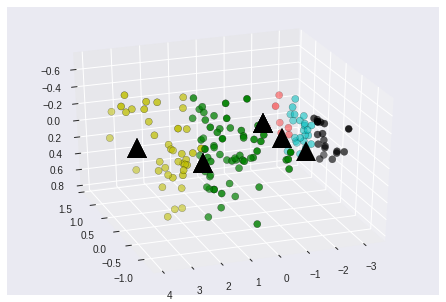

In [7]:
################  CPU Version #######################
start=time.time()
points_values,centroid_values,assignment_values=k_means()
end=time.time()
print "\n\n\n\nCPU Version:: Time taken ",(end-start)," sec\n\n\n"
plot(points_values,centroid_values,assignment_values)


In [9]:
## DO : Edit -> Notebook Settings -> Harware Accelaration -> Select GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0






Task 1 on CPU; Task 2 on GPU:: Time taken  1.61607980728  sec





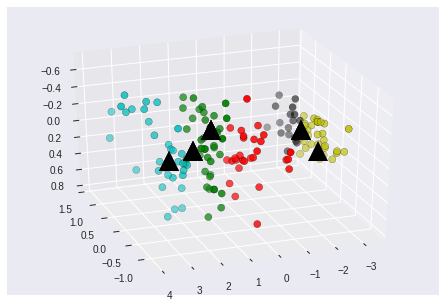

In [8]:

###########  Task 1 on CPU; Task 2 on GPU ############
start=time.time()
points_values,centroid_values,assignment_values=k_means(["/cpu:0","/device:GPU:0"])
end=time.time()
print "\n\n\n\nTask 1 on CPU; Task 2 on GPU:: Time taken ",(end-start)," sec\n\n\n"
plot(points_values,centroid_values,assignment_values)








Task 2 on CPU; Task 1 on GPU:: Time taken  0.757876873016  sec





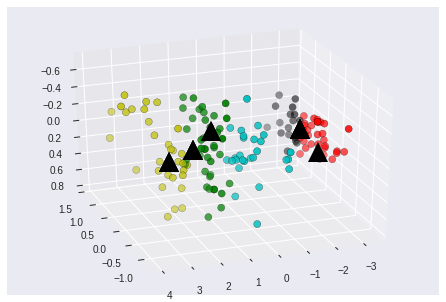

In [10]:
###########  Task 2 on CPU; Task 1 on GPU ############
start=time.time()
points_values,centroid_values,assignment_values=k_means(["/device:GPU:0","/cpu:0"])
end=time.time()
print "\n\n\n\nTask 2 on CPU; Task 1 on GPU:: Time taken ",(end-start)," sec\n\n\n"
plot(points_values,centroid_values,assignment_values)






Both on GPU:: Time taken  1.40512704849  sec





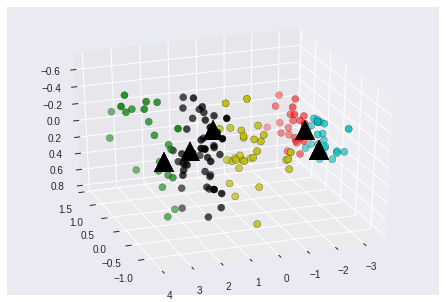

In [11]:
#############     Both on GPU    #####################
start=time.time()
points_values,centroid_values,assignment_values=k_means(["/device:GPU:0","/device:GPU:0"])
end=time.time()
print "\n\n\n\nBoth on GPU:: Time taken ",(end-start)," sec\n\n\n"
plot(points_values,centroid_values,assignment_values)
